In [1]:
import numpy as np
from scipy import integrate    
import matplotlib.pyplot as plt
import itertools
import arviz as az
import seaborn as sns
import pandas as pd
import pickle
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2g}'.format)

In [2]:
full_fit = pickle.load(open("results/gprotein/horseshoe_ndx_0.03.p", "rb"))
fit = full_fit['fit']
S = full_fit['S']
R = full_fit['R']
D = full_fit['D']

In [10]:
for i in range(4):
    print("%d : %f" % (i, np.mean(fit.sampler_variables()['lp__'][:,i])))

0 : -2443.696967
1 : -2423.873267
2 : -2395.858833
3 : -2392.843700


### Posteror

In [18]:
nonzero_idx = []
nonzero_D = []
samples = fit.stan_variables()['rates']
for i in range(samples.shape[0]):
    inferred_rates = samples[i,:]
    inferred_rates[inferred_rates < 1e-4] = 0
    nonzero_idx.append(np.argwhere(inferred_rates != 0)[:,0])

In [6]:
obs = pickle.load(open("results/gprotein/obs_0.03.p", "rb"))
t = obs["t"]
Z_obs = obs["Z_obs"]
Z_obs_noisy = obs["Z_obs_noisy"]
species_names = ['R', 'L', 'RL', 'G', 'Ga', 'Gbg', 'Gd']

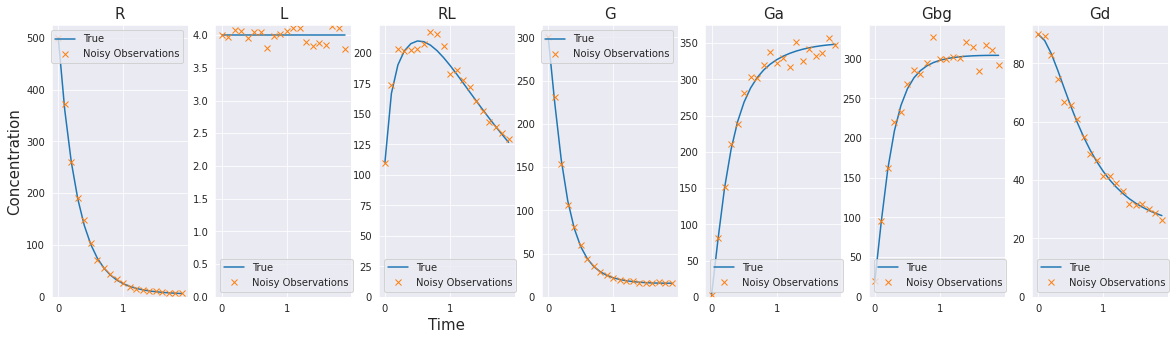

In [9]:
fig, ax = plt.subplots(1, 7)

for i in range(7):
    ax[i].plot(t, Z_obs[:,i], color = 'C0', label = 'True')
    ax[i].plot(t, Z_obs_noisy[:,i], 'x', color = 'C1', label = 'Noisy Observations')
    ax[i].legend()
    ax[i].set_title(species_names[i], fontsize = 15)
    ax[i].set_ylim([0, None])
ax[0].set_ylabel("Concentration", fontsize = 15)
ax[2].set_xlabel("Time", fontsize = 15)
fig.set_size_inches(20, 5)
plt.savefig("figures/gprotein_obs.png", dpi = 400)

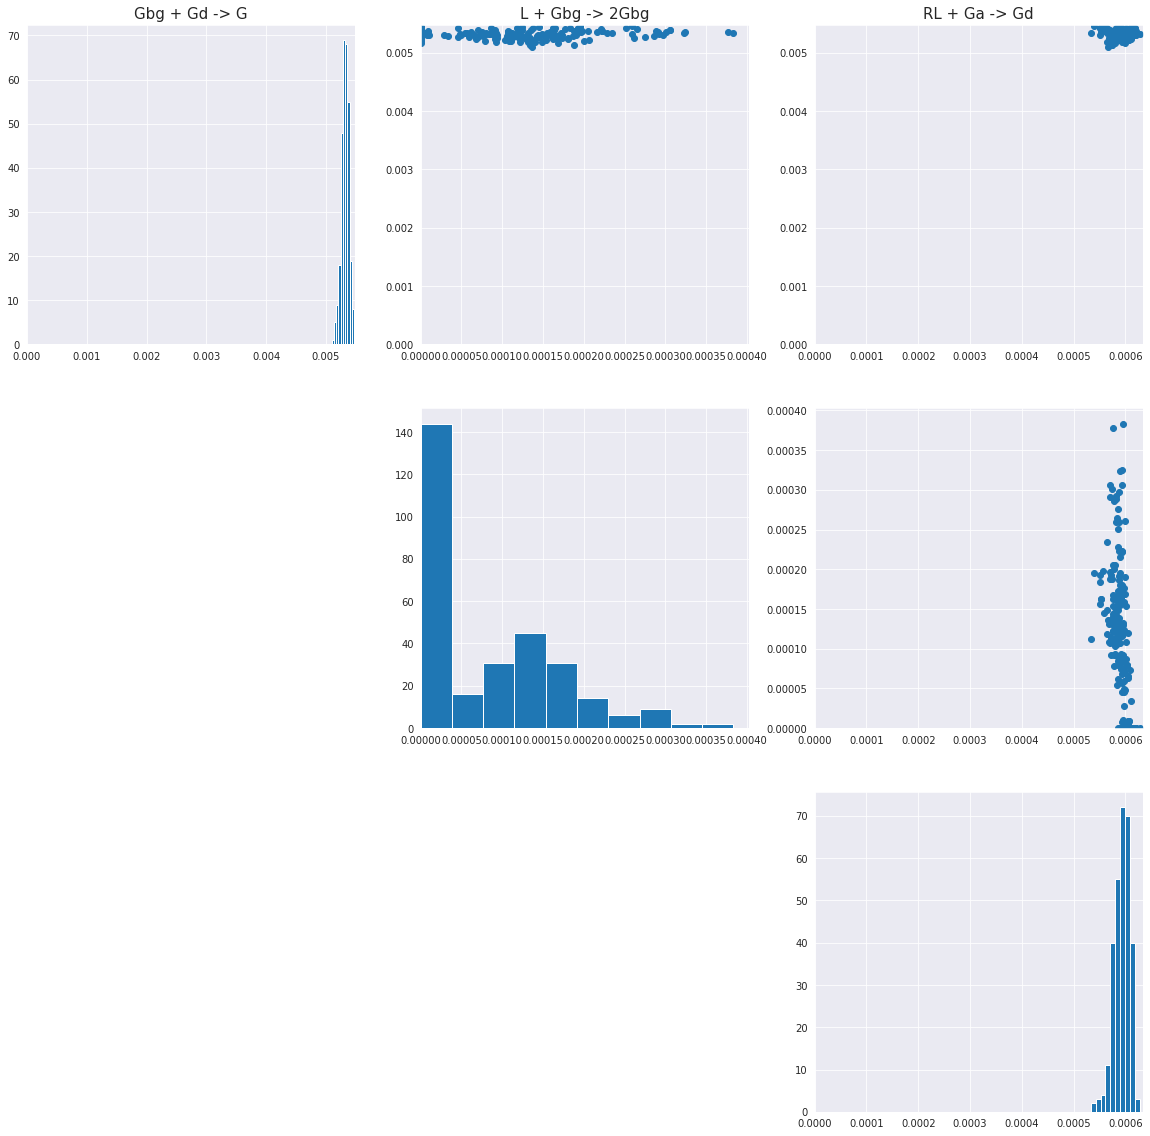

In [38]:
red_samples = samples[900:1200,nonzero_idx[900][5:]]

fig, ax = plt.subplots(red_samples.shape[1], red_samples.shape[1])
for i in range(red_samples.shape[1]):
    ax[0][i].set_title(D[nonzero_idx[900][5:][i]], fontsize = 15)
    for j in range(i, red_samples.shape[1]):
        if i == j:
            ax[i][j].hist(red_samples[:,i])
            ax[i][j].set_xlim([0, None])
        else:
            ax[i][j].scatter(red_samples[:,j], red_samples[:,i])
            ax[i][j].set_xlim([0, None])
            ax[i][j].set_ylim([0, None])
            ax[j][i].axis('off')
fig.set_size_inches(20, 20)
#plt.savefig("figures/argn_posterior_1.png", dpi = 400)

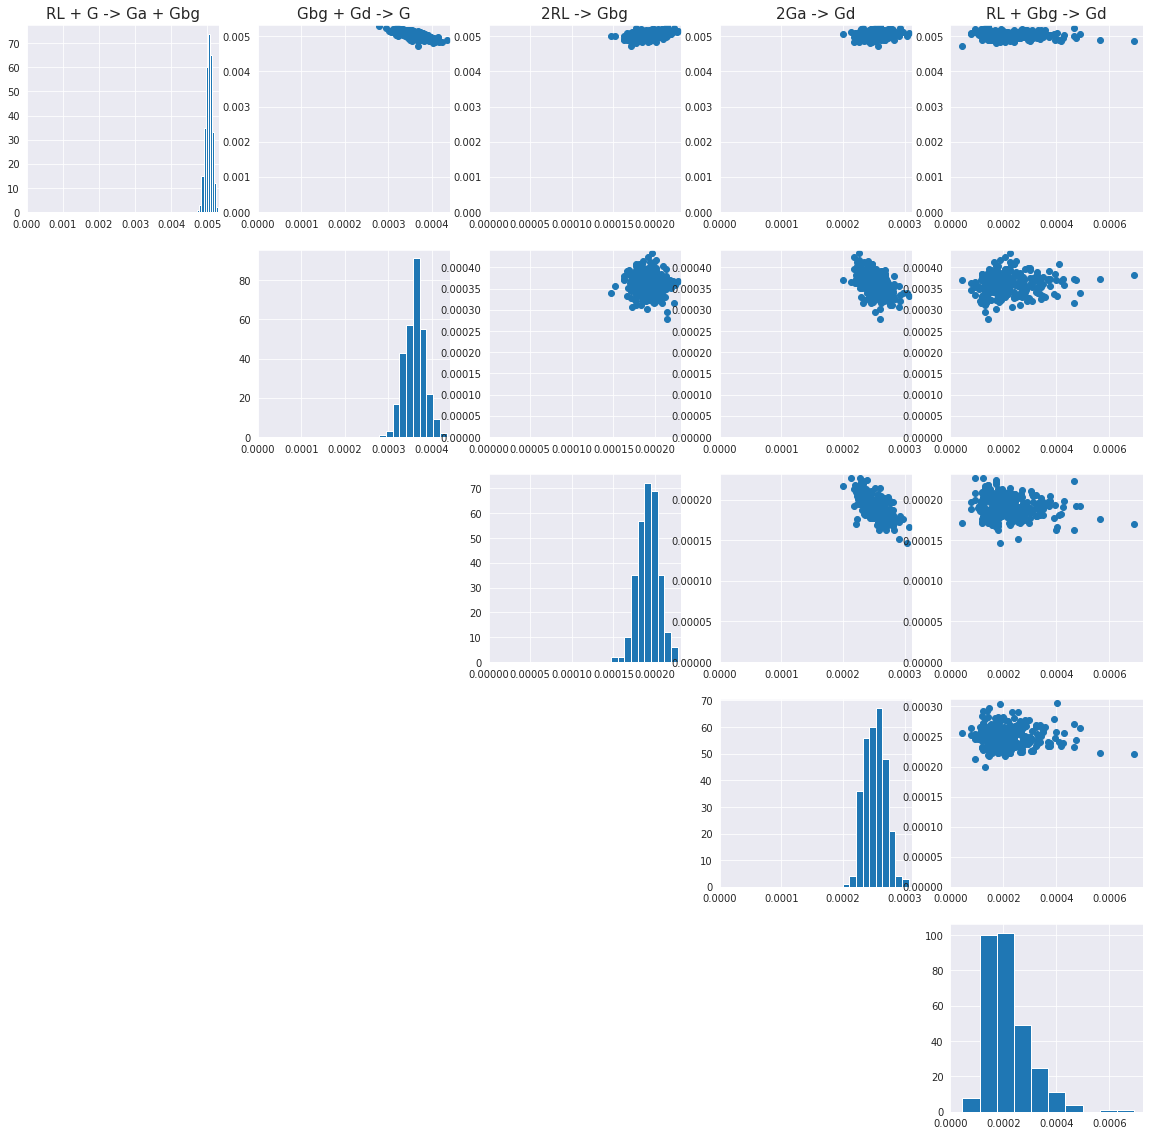

In [37]:
red_samples = samples[600:900,nonzero_idx[600][5:]]

fig, ax = plt.subplots(red_samples.shape[1], red_samples.shape[1])
for i in range(red_samples.shape[1]):
    ax[0][i].set_title(D[nonzero_idx[600][4:][i]], fontsize = 15)
    for j in range(i, red_samples.shape[1]):
        if i == j:
            ax[i][j].hist(red_samples[:,i])
            ax[i][j].set_xlim([0, None])
        else:
            ax[i][j].scatter(red_samples[:,j], red_samples[:,i])
            ax[i][j].set_xlim([0, None])
            ax[i][j].set_ylim([0, None])
            ax[j][i].axis('off')
fig.set_size_inches(20, 20)
#plt.savefig("figures/argn_posterior_2.png", dpi = 400)

In [20]:
np.percentile(red_samples, 50, axis = 0)

array([0.021     , 0.00531766, 0.        , 0.00059558])

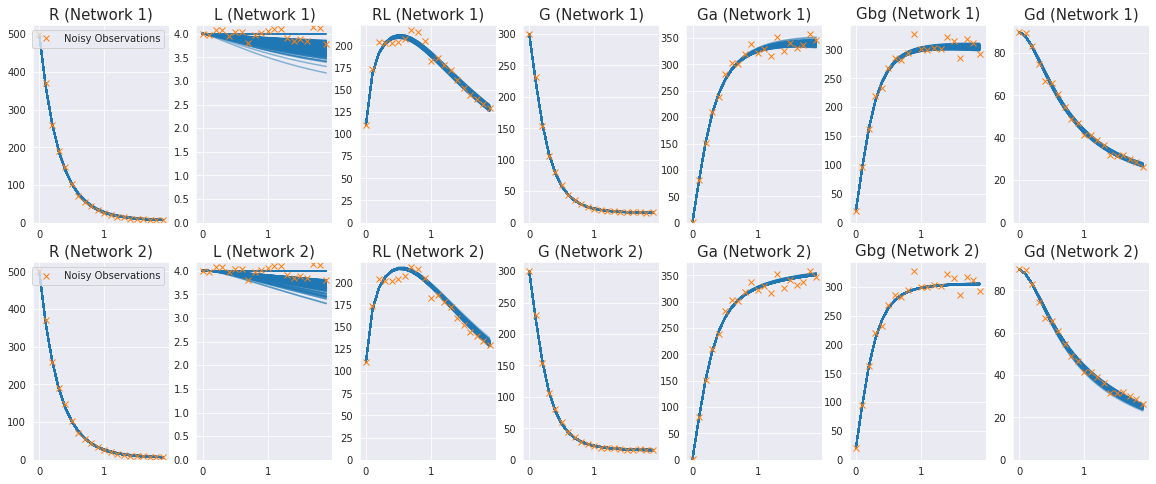

In [43]:
fig, ax = plt.subplots(2,7)
n_nonzero = []
n_nonzero_idx = []
n_nonzero_D = []
samples = fit.stan_variables()['rates']
for j in range(2,4):
    n_nonzero_chain = []
    n_nonzero_chain_D =  []
    n_nonzero_chain_idx = []
    for i in range(j * 300,j * 300 + 300):
        inferred_rates = samples[i,:]
        inferred_rates[inferred_rates < 1e-4] = 0
        n_nonzero_chain.append(np.sum(inferred_rates != 0))
        n_nonzero_chain_idx.append(np.argwhere(inferred_rates != 0)[:,0])
        n_nonzero_chain_D.append([D[k] for k in np.argwhere(inferred_rates != 0)[:,0]])
        def dZdt_inf(Z, t = 0):

            ap = np.hstack([Z, 1]) * (R == 1)
            ap += (np.hstack([Z, 1]) * (R == 2)) ** 2
            ap_mask = ap + (ap == 0).astype(np.float32)
            extend_Z = np.prod(ap_mask, axis = 1) * inferred_rates
            return (S.T @ extend_Z)[:-1]
        Z_obs_inf = integrate.odeint(dZdt_inf, [500, 4, 110, 300, 2, 20, 90], t)
        for k in range(7):
            ax[j-2][k].plot(t, Z_obs_inf[:, k], color = 'C0', alpha = 0.5);

    for k in range(7):
        ax[j-2][k].set_title("%s (Network %d)" % (species_names[k], j + 1 - 2), fontsize = 15)
        ax[j-2][k].plot(t, Z_obs_noisy[:,k], 'x', label = 'Noisy Observations', color = 'C1')
        ax[j-2][k].set_ylim([0, None])


    ax[j-2][0].legend()
    n_nonzero.append(n_nonzero_chain)
    n_nonzero_D.append(n_nonzero_chain_D)
    n_nonzero_idx.append(n_nonzero_chain_idx)
fig.set_size_inches(20, 8)
#plt.savefig("figures/argn_recovered_trajectories.png", dpi = 400)

In [46]:
samples = fit.stan_variables()['rates']
p_samples = [
    samples[600:900,nonzero_idx[600][4:]],
    samples[900:1200,nonzero_idx[900][4:]]
]
for k in range(2):
    print("Reaction Network %d" % k)
    median_values = np.percentile(p_samples[k], 50, axis = 0)
    for i in range(len(n_nonzero_D[k][0])):
        if i < 4:
            print("%d (%d): %s" % (i + 1, n_nonzero_idx[k][0][i], n_nonzero_D[k][0][i]))
        else:
            print("%d (%d) %f: %s" % (i + 1, n_nonzero_idx[k][0][i], median_values[i -4 ], n_nonzero_D[k][0][i]))

Reaction Network 0
1 (0): 0 -> R
2 (1): R -> 0
3 (2): R + L -> L + RL
4 (3): RL -> R
5 (4) 0.021000: RL + G -> Ga + Gbg
6 (6) 0.005038: Gbg + Gd -> G
7 (157) 0.000362: 2RL -> Gbg
8 (270) 0.000192: 2Ga -> Gd
9 (628) 0.000252: RL + Gbg -> Gd
10 (784) 0.000194: L + RL -> Gbg + Gd
Reaction Network 1
1 (0): 0 -> R
2 (1): R -> 0
3 (2): R + L -> L + RL
4 (3): RL -> R
5 (4) 0.021000: RL + G -> Ga + Gbg
6 (6) 0.005318: Gbg + Gd -> G
7 (195) 0.000058: L + Gbg -> 2Gbg
8 (336) 0.000596: RL + Ga -> Gd
